In this example, we will use KNN classifier to detect anomalies in real network traffic information. The training data used is from real network captures and is from University of Brunswick.

Assignment:
Run all the Steps below and understand the process of how KNN classifier is used for anomaly detection. Understand the features, the training classifiers and the distance metric used. **You do not have to write any code. Just run the steps and understand what is happening in each step!**

Note: the data file (KDDTrain+.txt) is provided in the zip file from the lecture. Upload the data file into the sample data folder (as shown in the lecture). The file is 19MB and takes a minute to upload to Colab.

The final step should take approx 15 mins to run and output to appear.

Step 1: Import all the libs

In [1]:
# Import all the libs

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

Step 2: Load the data sample and print the first five rows in the dataset.

In [2]:
#Data sample from University of New Brunswick, Canada (https://www.unb.ca/cic/datasets/nsl.html)
data_train = pd.read_csv("/content/KDDTrain+.txt")

In [3]:
data_train.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.18,2,2.1,0.00,0.00.1,0.00.2,0.00.3,1.00,0.00.4,0.00.5,150,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Step 3: Rename the columns based on network parameters.

In [4]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

In [5]:
data_train.columns = columns
data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Step 4: Create a gradient map to visualize parameters with large values

In [6]:
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


Step 5: Label the normal and attack for datapoints

In [7]:
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

Step 6: Plot a graph to visualize the data based on the labelling from Step 5.

In [8]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

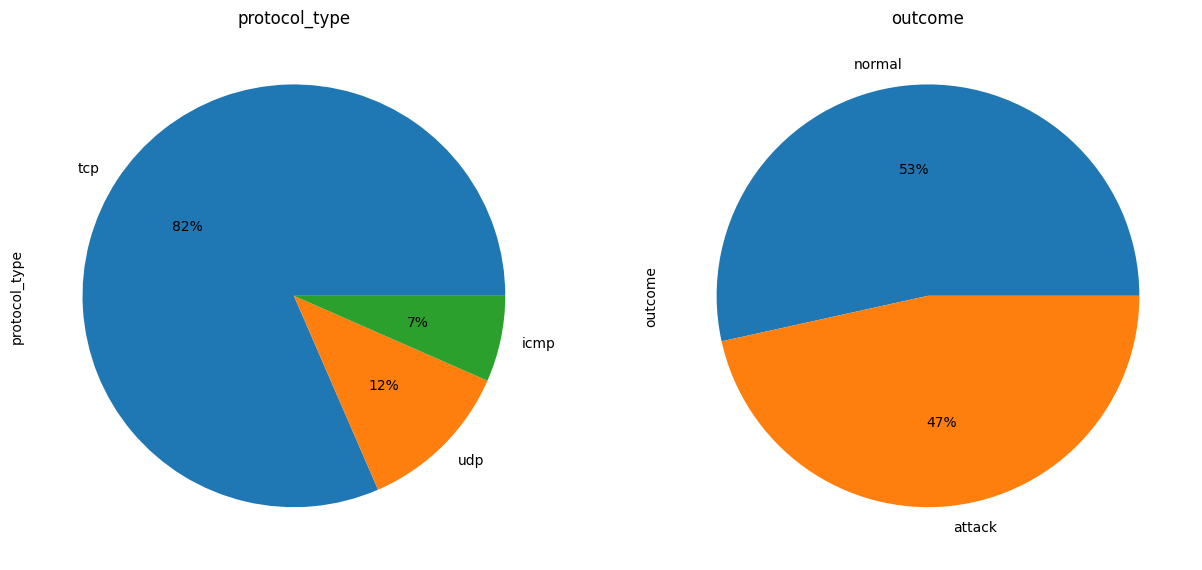

In [9]:
pie_plot(data_train, ['protocol_type', 'outcome'], 1, 2)

Step 7: Preprocessing the Data


In [10]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [11]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [12]:
scaled_train = preprocess(data_train)

Step 8: Principal Component Analysis:

 Technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset

In [13]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


Step 9: Evaluate the model

In [14]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))

    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Step 10: Modelling with KNN and running it over the dataset (Be patient, it takes around 12 minutes to get the output. Keep the tab open)

Training Accuracy KNeighborsClassifier 99.05236313841452  Test Accuracy KNeighborsClassifier 98.93629688430245
Training Precesion KNeighborsClassifier 99.22512234910276  Test Precesion KNeighborsClassifier 99.05636317266003
Training Recall KNeighborsClassifier 98.73133850195424  Test Recall KNeighborsClassifier 98.67050554661698


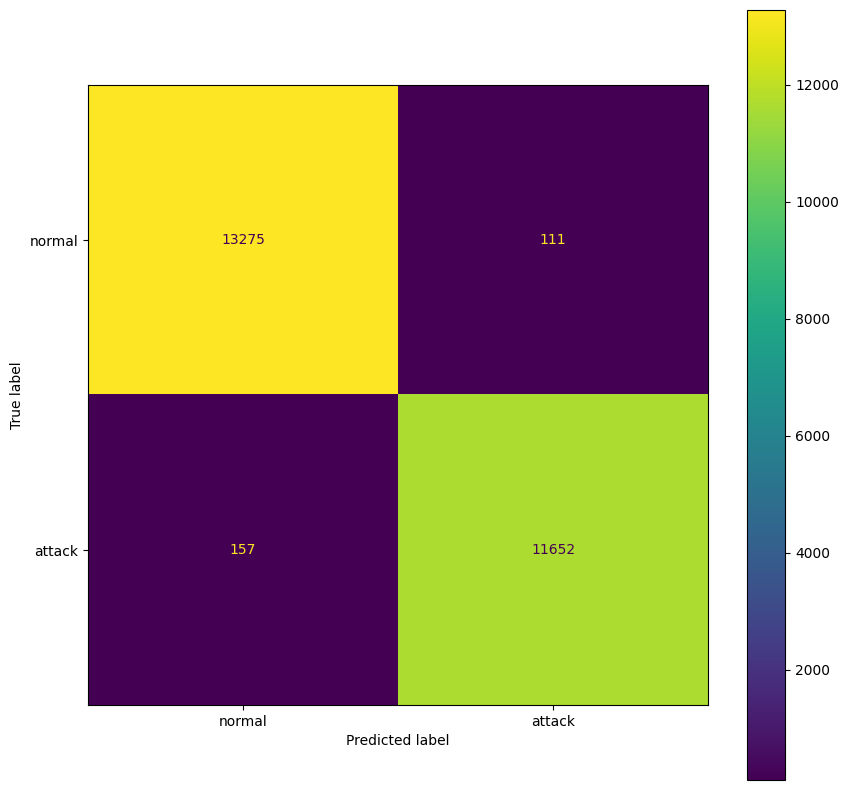

In [15]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)